# Numerical computation with numpy

The main Python library for numerical work is [NumPy](http://www.numpy.org/).
It’s vital to be
familiar with it for almost any work in machine learning &mdash; the standard machine learning libraries like PyTorch need high performance numerical computation, and their libraries are designed to mimic NumPy.

#### Contents

* [1. Preamble](#1.-Preamble)
* [2. Vectorized thinking](#2.-Vectorized-thinking)
  * [2.1 A FIRST SESSION](#2.1-A-FIRST-SESSION)
  * [2.2 VECTORIZED LIBRARY ROUTINES](#2.2-VECTORIZED-LIBRARY-ROUTINES)
  * [2.3 FOR LOOPS CONSIDERED HARMFUL](#2.3-FOR-LOOPS-CONSIDERED-HARMFUL)
* [3. Arrays](#3.-Arrays)
  * [3.1 VECTORIZED OPERATIONS ON ARRAYS](#3.1-VECTORIZED-OPERATIONS-ON-ARRAYS)
  * [3.2 ARRAY SLICING AND INDEXING](#3.2-ARRAY-SLICING-AND-INDEXING)
  * [3.3 LINEAR ALGEBRA](#3.3-LINEAR-ALGEBRA)
* [4. Simulation](#4.-Simulation)

## 1. Preamble

At the top of almost
every piece of scientific computing work, we’ll import these standard modules. We’ll also give them
short aliases so we can write e.g. np.foo rather than numpy.foo.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## 2. Vectorized thinking

We saw Python lists in section 1. We can of course store numbers in Python lists: a list to store a
vector, a list of lists to store a matrix, and so on. For scientific computing, this is not a good idea.

* Python lists are flexible: they can store mixed data types e.g. integers mixed with strings and
sublists and even functions. But this flexibility comes with a performance hit. For scientific
computing, where we don’t need the flexibility, it’s better to use specialised classes for numeric
vectors and arrays. When the machine knows what datatypes to expect, it can compute faster.

* Mathematicians have lovely concise notation for vector algebra and matrices. By using specialised
classes, we can use similar syntax in our code. This will be more concise and easier to
debug, than if we used regular Python lists for everything.

The core skill is _vectorized thinking_, which means writing our code in terms of functions that operate
on entire vectors (or arrays) at once.

### 2.1 A FIRST SESSION

In [ ]:
x = np.array([1,2,5,3,2])     # [1, 2, 5, 3, 2]
y = np.ones(5)                # [1.,1.,1.,1.,1.]
z = np.arange(5)              # [0, 1, 2, 3, 4]

# We can do maths on vectors, applying the operations elementwise
# We can mix vectors and scalars
(x + 1) * 2                   # [4, 6, 12, 8, 6]
(x + y) * z                   # [0., 3.,12.,12.,12.]
x >= 3                        # [False, False, True, True, False]
np.where(x>=3, x, 3)          # [3, 3, 5, 3, 3]

# Python slicing and indexing notation works
x[:3]                         # [1, 2, 5]
x[x>=3] = -10                 # x is now [1, 2, -10, -10, 2]

All the elements of a numpy vector have to be the same type. It can be integer, or floating point, or
boolean. To see the type of a vector, `x.dtype`. When you create an array, you can specify the `dtype`. To cast to another type, `x.astype(int)`.

In [ ]:
(x>=2).dtype                  # bool
np.array([1,2], dtype=float)  # [1.0, 2.0]
(x>=2).astype(int)            # [0, 1, 0, 0, 1]

### 2.2 VECTORIZED LIBRARY ROUTINES

To be good at writing vectorized code, we need to know what sorts of calculations we can do on
vectors. Here are some useful routines, and a [full reference](https://docs.scipy.org/doc/numpy/reference/routines.html#routines).

To [create vectors](https://numpy.org/doc/stable/reference/routines.array-creation.html),
* `np.array([1,2,3])` creates a numpy vector from a Python list
* `np.zeros(n)`, `np.ones(n)`, `numpy.full(n,fill_value)`
* `numpy.ones_like(a)` creates a vector of the same shape as a
* `np.arange(n)` creates $[0,1,...,n-1]$
* `np.linspace(start,stop,n)` creates n evenly-spaced points between start and stop inclusive, very
useful for plotting


For [maths](https://docs.scipy.org/doc/numpy/reference/routines.math.html#mathematical-functions) and
[statistics](https://docs.scipy.org/doc/numpy/reference/routines.statistics.html),
* Normal mathematical expressions work on vectors, and you can mix vectors and scalars
* `np.sin`, `np.exp`, `np.floor`, …
* `x @ y` gives the dot product, `np.linalg.norm(x)` is the norm
* `np.sum`, `np.mean`, and `np.prod`; also `np.cumsum(x)` gives $[x_0, x_0 + x_1, x_0 + x_1 + x_2, \dots ]$
* `np.min(x)` and `np.max(x)` for the overall min and max; `np.minimum(x,y)` for the element-wise
mininmum

For random numbers, it's good practice to set the seed explicitly, so that your code is reproducible. That makes it much easier to debug. Call `rng = np.random.default_rng(x)` for some arbitrary integer seed `x`, and then use it to generate [random values of various types]:(https://numpy.org/doc/stable/reference/random/generator.html#simple-random-data)
* `rng.random(n)` for $n$ floating point values in the range $[0,1]$
* `rng.choice(a,n)` to pick $n$ elements at random from the list $a$



**Worked example.** Here's an illustration: computing the [correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between two vectors $x$ and $y$,
$$
\rho = \frac{\sum_i (x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\sum_i(x_i-\bar{x})^2} \sqrt{\sum_i (y_i-\bar{y})^2}}
$$
where $x$ and $y$ have the same length $N$, and
$$
\bar{x} = \frac{1}{N} \sum_i x_i, \qquad
\bar{y} = \frac{1}{N} \sum_i y_y.
$$
Here are two implementations, one written in Python-style, one written in scientific computing style,
to compute $\rho$. The latter is roughly 15 times faster. (The [magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time) command `%%time` at the start of a
cell makes the notebook print out the execution time.) 

<div style="font-size: 75%">
Although, if we really knew our way round numpy, we'd just use <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html#numpy.corrcoef"><code>np.corrcoef</code></a>
    </div>

In [ ]:
# Set up some parameters
N = 10000000
rand_seed = 161803

# Assume numpy is already imported
# Also load the libraries for pure Python code
import math, random

In [ ]:
%%time
# Python-style code

random.seed(rand_seed)
# Create two lists of random numbers, xs and ys
xs = [random.random() for i in range(N)]
ys = [xs[i] + random.random() for i in range(N)]
# Compute the various terms involved in the formula
xbar = sum(xs) / N # sum(list) is built into Python
ybar = sum(ys) / N
sxy = sum([(x-xbar)*(y-ybar) for x,y in zip(xs,ys)])
sxx = sum([(x-xbar)**2 for x in xs])
syy = sum([(y-ybar)**2 for y in ys])
ρ = sxy / math.sqrt(sxx) / math.sqrt(syy)
print(ρ)

In [ ]:
%%time
# Vectorized code
rng = np.random.default_rng(rand_seed)
# Create two random vectors x and y
x = rng.random(N)
y = x + rng.random(N)
# Compute the terms in the formula. Note: @ means ”dot product”
xbar = np.sum(x) / N
ybar = np.sum(y) / N
ρ = ((x-xbar) @ (y-ybar)) / np.sqrt(np.sum((x-xbar)**2) * np.sum((y-ybar)**2))
print(ρ)

### 2.3 FOR LOOPS CONSIDERED HARMFUL

Vectorized thinking isn’t just for mathematical formulae &mdash;
there are all sorts of programming constructs
that can be vectorized also. In general, whenever you find yourself writing a for loop or a
Python [list comprehension](notes1_python.ipynb#listcomprehension), stop and see if you can vectorize your code. You’ll usually end up with something more flexible for scientific computing.

Functions for indexing:
* the usual [slice notation](notes1_python.ipynb#slice) works on numpy vectors, e.g. `x[:10]` or `x[10:]` or `x[:-3]`
* `np.where(b)` gives a vector of indexes at which the boolean vector $b$ is True
* index a vector using a vector of booleans, e.g. `x[y>5]`
* index a vector using a vector of integers, e.g. `i=np.where(y>5); x[i]`
* update part of a vector, e.g. `x[x<3] = x[x<3] + 10`
* `np.concatenate([v1,v2])` concatenates two or more vectors

General programming functions:
* `len(x)` gives the length of a vector
* `np.any`, `np.all`, and other [logic functions](https://docs.scipy.org/doc/numpy/reference/routines.logic.html#logic-functions)
* `np.unique` returns the unique elements of a vector
* `np.isin(x,vals)` returns a vector, the same shape as $\textsf{x}$, recording whether or not each element of
$\textsf{x}$ is in $\textsf{vals}$
* `∼x` is logical negation, the equivalent of Python’s `not x`; also `(x & y)` and `(x | y)` both work
* `np.count_nonzero(x)` counts the number of entries where $\textsf{x}$ is $\textsf{True}$ or non-zero
* `x.sort()` sorts a vector in-place, and `np.sort(x)` creates a new vector which is a sorted version of
$\textsf{x}$
* `np.argsort(x)` gives the vector of indexes that would put $\textsf{x}$ in order, i.e. it produces an integer
vector $\textsf{i}$ such that $\textsf{x[i]}$ is sorted; also see other [sorting functions](https://docs.scipy.org/doc/numpy/reference/routines.sort.html#sorting)
* `np.argmax` and other [search functions](https://docs.scipy.org/doc/numpy/reference/routines.sort.html#searching)
* `np.where(cond,x,y)` is the vectorized version of Python’s $\textsf{x if cond else y}$
* There are [vectorized string functions](https://numpy.org/doc/stable/reference/routines.char.html#module-numpy.char), for example `np.char.add(s1,s2)` and `np.char.lower(s)`

Cheating
* `g = np.vectorize(f)` is a vectorized version of an arbitrary Python function , so you can call $\textsf{g(x)}$ on a vector $\textsf{x}$. It gives you the nice vectorized syntax, but under the hood it's really a slow $\textsf{for}$ loop, so avoid it if you can

**Worked example.** Suppose we want to sort a vector of strings by length, breaking ties alphabetically.

1. Get a vector with the length of each string. Digging around the documentation for string functions, we find `np.char.str_len`.
2. Work out how to put lengths in order, breaking ties alphabetically by names. Digging around
the documentation for sorting, we find `np.lexsort([y,x])`, which returns sorting indexes like
$\textsf{np.argsort(x)}$, but breaks ties in $\textsf{x}$ by another vector $\textsf{y}$. This is called lexicographical sorting.
3. Pick out the names in the order specified by these indexes.

In [ ]:
names = np.array(['alexis','chloe','guarav','shay','adrian','rebecca'])
lengths = np.char.str_len(names)
i = np.lexsort([names, lengths])
names[i]

## 3. Arrays

NumPy supports matrices and higher-dimensional arrays. To enter a 2d array (i.e. a matrix) like
$$
a =
\begin{bmatrix}
2.2 & 3.7 & 9.1\\
−4 & 3.1 & 1.3
\end{bmatrix}
$$
we type in

In [ ]:
a = np.array([[2.2, 3.7, 9.1], [-4, 3.1, 1.3]])

Use `a.shape` to find the dimensions of an array. In fact, vectors are nothing other than one-dimensional
arrays, and their shape is a tuple of length 1. NumPy doesn’t have any concept of ‘row vector’ versus
‘column vector’ &mdash; it’s only 2d arrays that can be described in that way.

In [ ]:
a.shape                       # (2,3) — a matrix
np.array([5,6,4]).shape       # (2,) — a vector
np.array([[5,6,4]]).shape     # (1,3) — a row
np.array([[5],[6],[4]]).shape # (3,1) — a column

### 3.1 VECTORIZED OPERATIONS ON ARRAYS

Most of the standard vectorized operations can be applied to arrays, though now you have a choice about which dimension to apply them to.

In [ ]:
np.sum(a, axis=0)  # vector of column sums
np.sum(a, axis=1)  # vector of tow sums
np.sum(a)          # scalar with total sum

### 3.2 ARRAY SLICING AND INDEXING

To refer to a subarray, we can use an extended version of Python’s slice notation.

In [ ]:
a[:, :2]                   # all rows, first two columns
a[1, :]                    # second row (indexes start at 0), all columns
a[1]                       # another way to fetch the second row
a[:2, :2] = [[1,2],[3,4]]  # assign to a submatrix

There are two ways to refer to an arbitrary set of elements inside the array, both known as [advanced
indexing](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#advanced-indexing).

In [ ]:
a = np.zeros((3,3), dtype=int)

# Boolean advanced indexing
i = np.array([[False,True,False],[True,False,False],[False,False,True]])
a[i] = [6,7,8]

# Integer advanced indexing
ix,iy = [0,1,2], [1,0,2]
a[ix,iy] = [6,7,8]

# Both produce the same result.

<pre>array([[0, 6, 0],
       [7, 0, 0],
       [0, 0, 8]])</pre>

For 1d vectors the only reshaping operations are slicing and concatenating, but for higher dimensional
arrays there is a whole variety of [reshaping functions](https://docs.scipy.org/doc/numpy/reference/routines.array-manipulation.html#array-manipulation-routines) such as stacking, tiling, transposing, etc. The
most useful operation is adding a new dimension, for example to turn a one-dimensional vector into
a column vector. The second most useful is stacking vectors to form an array.

In [ ]:
x = np.array([1,2,3])
x[:, None]   # can also be written x[:, np.newaxis], or x[..., None]

<pre>array([[1],
       [2],
       [3]])</pre>

In [ ]:
np.column_stack([[1,2], [3,4], [5,6]])

<pre>array([[1, 3, 5],
       [2, 4, 6]])</pre>

NumPy also has a powerful tool called [broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) which generalizes ‘add a scalar to a vector’,
and which is used a lot in more advanced array-manipulating code. It’s more advanced than we need
for this course, but it’s used a lot in machine learning and it’s worth reading about. Here’s a simple
example, normalizing a matrix so the columns sum to 1.

In [ ]:
a = np.array([[3,2,8],[2,6,2]])
colsums = np.sum(a, axis=0)
a / colsums

<pre>array([[0.6 , 0.25, 0.8 ],
       [0.4 , 0.75, 0.2 ]])</pre>

### 3.3 LINEAR ALGEBRA

In Easter term you will study linear algebra in the Maths for Natural Sciences course. If you want to
try out the maths, you’ll find relevant functions in [np.linalg](https://docs.scipy.org/doc/numpy/reference/routines.linalg.html) and [np.dual](https://docs.scipy.org/doc/numpy/reference/routines.dual.html).
In particular, see [np.linalg.solve](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) for solving systems of linear equations.

## 4. Simulation

Simulation is a mainstay of scientific computing. A common style with numpy is to predefine an vector
or array to store the results, one row per timestep, and then iterate over timesteps gradually filling in
the array. (This is the one case where for loops are appropriate.) Here’s an example, a differential
equation simulation. A standard model for an epidemic is the SIR model, which specifies how the number of Susceptible, Infectious, and Recovered people evolves over time. For a total population of size $N$,
$$
\begin{aligned}
\frac{dS_t}{dt} &= -r_0 \gamma \frac{I_t S_t}{N}\\
\frac{dI_t}{dt} &= r_0 \gamma \frac{I_t S_t}{N} - \gamma I_t\\
\frac{dR_t}{dt} &= \gamma I_t,
\end{aligned}
$$
where $1/\gamma$ is the time it takes for an infections person to recover. (These differential equations are for a "friendly" epidemic which is non-lethal and in which you can't get reinfected. Can you see how to modify them to include deaths and reinfections?)

We might simulate this as follows.

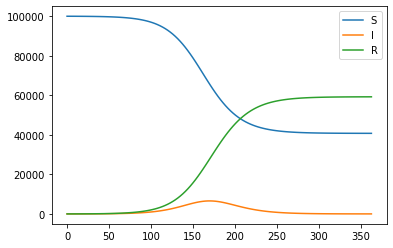

In [97]:
r0 = 1.5    # reproduction number
γ = 1/10    # recovery time is 10 days
T = 365     # total duration to simulate
dt = 3      # time step granularity of simulation

x0 = [99990.0, 10.0, 0.0]         # initial state

# initialization
num_iterations = np.ceil(T/dt).astype(int)
res = np.zeros((num_iterations, 4))         # matrix to store t,S,I,R
res[0,1:] = x0
res[:,0] = np.arange(num_iterations) * dt

# loop
for i in range(1, num_iterations):
    S,I,R = res[i-1, 1:]
    N = S+I+R
    d = np.array([-r0*γ*I*S/N, r0*γ*I*S/N-γ*I, γ*I])
    res[i, 1:] = res[i-1, 1:] + d*dt
    
# plot the output (see section 3 for more about plotting)
fig,ax = plt.subplots()
for col,lbl in zip([1,2,3], ['S','I','R']):
    ax.plot(res[:,0], res[:,col], label=lbl)
plt.legend()
plt.show()

This simulation is simple and naive.
* From a mathematical point of view it’s naive, because there are much more sophisticated [numerical
methods for solving differential equations](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.integrate.ode.html).
* From a computer science point of view this isn’t ideal, because the code tangles together the
iteration logic with the logging logic. It should really be rewritten with lazy lists.
* But from a scientific computing point of view, simulations like this are so easy to put together
and learn from, that they are invaluable.

What we have coded is called a _discrete-time simulation_, because time advances in fixed increments.
In IA Algorithms you will study the ‘heap’ data structure, which is good simulation in which time is
pegged to changes in state, called _event-driven simulation._